In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import pyBigWig
import copy
import math

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from scipy.sparse import coo_matrix
from scipy.stats import spearmanr,pearsonr

In [6]:
import huggingface
import standalone_hyenadna

/cluster2/huanglab/liquan/miniconda3/envs/eScreen/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
!pip install transformers==4.26.0
!pip install omegaconf

In [20]:
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset

class SeqDataset(Dataset):
    def __init__(self, sequences, labels, celltypes, vocab=None):
        self.sequences = sequences
        self.labels = labels
        self.celltypes = celltypes
        
        # 如果你没有提前定义字典，这里自动创建一个简单的碱基映射
        if vocab is None:
            vocab = {'A': 0, 'C': 1, 'G': 2, 'T': 3, 'N': 4}
        self.vocab = vocab

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq   = self.sequences[idx]
        label = self.labels[idx]
        ct    = self.celltypes[idx]
        return seq, label, ct

def train(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, 
          learning_rate: float, num_epochs: int, device: torch.device):
    """
    训练模型的主循环。

    参数:
    model (nn.Module): 要训练的模型。
    train_loader (DataLoader): 训练数据的 DataLoader。
    val_loader (DataLoader): 验证数据的 DataLoader。
    learning_rate (float): 初始学习率。
    num_epochs (int): 训练的周期数。
    device (torch.device): 训练设备 ('cuda' 或 'cpu')。
    """
    # 1. 初始化优化器和损失函数
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # 使用CrossEntropyLoss处理one-hot标签
    loss_fn = nn.CrossEntropyLoss()

    # 2. 将模型移动到目标设备
    model.to(device)

    print(f"Starting training for {num_epochs} epochs on device: {device}")

    for epoch in range(num_epochs):
        # --- 训练阶段 ---
        model.train() # 设置为训练模式
        train_loss = 0.0
        
        # 使用 tqdm 封装 DataLoader 以显示进度
        train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Train)")
        
        for batch_idx, (seq, target, ct) in enumerate(train_loop):
            # 1. 数据移动到设备
            # DNA独热编码 (B, L, 4) -> (B, 4, L)
            #data = data.float().permute(0, 2, 1).to(device) 
            # target已经是one-hot形式 (B, 2)，不需要转换
            target = target.to(device)  # 保持 (B, 2) 形状
            
            # 2. 前向传播
            output = model(seq,ct)
            # 3. 计算损失 - 使用CrossEntropyLoss处理one-hot标签
            loss = loss_fn(output, target)

            # 4. 反向传播和优化
            optimizer.zero_grad() # 梯度清零
            loss.backward() # 反向传播
            optimizer.step() # 更新参数

            train_loss += loss.item() * len(seq)
            train_loop.set_postfix(loss=loss.item())

        avg_train_loss = train_loss / len(train_loader.dataset)

        # --- 验证阶段 ---
        model.eval() # 设置为评估模式
        val_loss = 0.0
        correct_predictions = 0
        
        with torch.no_grad(): # 禁用梯度计算
            for seq, target, ct in val_loader:
                #data = data.float().permute(0, 2, 1).to(device)
                target = target.to(device)  # 保持 (B, 2) 形状

                output = model(seq, ct)
                loss = loss_fn(output, target)
                val_loss += loss.item() * len(seq)

                # 计算准确率 - 使用argmax获取预测类别
                # output形状 (B, 2)，取最大值的索引作为预测类别
                predicted_classes = torch.argmax(output, dim=1) 
                # target形状 (B, 2)，取最大值的索引作为真实类别
                true_classes = target
                correct_predictions += (predicted_classes == true_classes).sum().item()

        avg_val_loss = val_loss / len(val_loader.dataset)
        val_accuracy = correct_predictions / len(val_loader.dataset)

        print(f"\nEpoch {epoch+1} Summary:")
        print(f"  Train Loss: {avg_train_loss:.4f}")
        print(f"  Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.4f}")

    print("Training finished.")


def predict(model: nn.Module, data_loader: DataLoader, device: torch.device) -> torch.Tensor:
    """
    对给定数据集进行预测。

    参数:
    model (nn.Module): 训练好的 Sei 模型。
    data_loader (DataLoader): 待预测数据的 DataLoader。
    device (torch.device): 预测设备 ('cuda' 或 'cpu')。

    返回:
    torch.Tensor: 模型的输出 (Sigmoid激活后的概率值)。
    """
    model.to(device)
    model.eval() # 设置为评估模式
    all_predictions = []

    print("Starting prediction...")
    
    with torch.no_grad(): # 禁用梯度计算
        for SEQ, _, CT in tqdm(data_loader, desc="Predicting"):
            # 前向传播
            output = model(SEQ, CT)
            all_predictions.append(output.cpu())

    # 拼接所有批次的预测结果
    return torch.cat(all_predictions, dim=0)

In [9]:
class FineTunedHyenaModel(nn.Module):
    
    def __init__(self,model,tokenizer,d_model,celltype_num=32,device='cpu'):
        
        super().__init__()
        
        self.HyenaDNAcore = model
        self.tokenizer    = tokenizer
        self.d_model      = d_model
        self.celltype_num = celltype_num
        
        self.celltype_emb = nn.Embedding(num_embeddings=celltype_num, embedding_dim=d_model)
        
        self.classifier = nn.Linear(d_model*2,2)
        
        self.device = device
        
    def forward(self,seq,ct):
        emb = self.tokenizer(seq)["input_ids"]
        emb = torch.LongTensor(emb).unsqueeze(0).to(self.device)
        #print(type(emb));assert 1==0

        ct_emb = self.celltype_emb(ct.to(self.device))
        #print(ct_emb.shape);assert 1==0
        #print(emb.shape,ct_emb.shape);assert 1==0
        
        output = []
        
        for x in emb:
            x = self.HyenaDNAcore(x)[:,-1,:]
            #print(x.shape,z.shape);assert 1==0
            x = torch.concatenate([x,ct_emb],dim=1)
            x = self.classifier(x)
            output.append(F.softmax(x,dim=1))
        return torch.concatenate(output,dim=0)

In [18]:
import pickle
from tqdm import tqdm

with open('/cluster2/huanglab/liquan/data/eSCREEN/Demo/data/demo_dataset.pkl','rb') as file:
    data = pickle.load(file)

trainset = data['Trainset']
testset  = data['Testset']
validset = data['Validset']

base_to_array={'A':[1,0,0,0],'C':[0,1,0,0],'G':[0,0,1,0],'T':[0,0,0,1],'N':[0,0,0,0]}

cell_type_dict = {'K562':0,'HepG2':1,'hPSC':2,'A549':3}

def one_hot(seq):return np.stack( np.array( [base_to_array[a] for a in seq] ) )

X_train = trainset['sequence'].values
Y_train = torch.tensor(trainset['label'].values)
Z_train = torch.tensor(np.stack([cell_type_dict[ct] for ct in trainset['cell_line'].values])).int()

X_test = testset['sequence'].values
Y_test = torch.tensor(testset['label'].values)
Z_test = torch.tensor(np.stack([cell_type_dict[ct] for ct in testset['cell_line'].values])).int()

X_valid = validset['sequence'].values
Y_valid = torch.tensor(validset['label'].values)
Z_valid = torch.tensor(np.stack([cell_type_dict[ct] for ct in validset['cell_line'].values])).int()

train_data   = SeqDataset(X_train, Y_train, Z_train)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

test_data   = SeqDataset(X_test, Y_test, Z_test)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

valid_data   = SeqDataset(X_valid, Y_valid, Z_valid)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [21]:
tokenizer = standalone_hyenadna.CharacterTokenizer(
    characters=['A', 'C', 'G', 'T', 'N'],  # add DNA characters
    model_max_length=1024,
)

Hyena = huggingface.HyenaDNAPreTrainedModel.from_pretrained(
    './pretrained_model/','tiny-1k'
)

model = FineTunedHyenaModel(model=Hyena,tokenizer=tokenizer,d_model=128,device='cuda:0')
model = model.to('cuda:0')
LR = 1e-4
EPOCHS = 20
train(model, train_loader, test_loader, LR, EPOCHS, device)

torch.save(model,'HyenaDNA.pth')

Loaded pretrained weights ok!
Starting training for 20 epochs on device: cuda:0


Epoch 1/20 (Train): 100%|██████████| 1385/1385 [00:44<00:00, 31.40it/s, loss=0.623]



Epoch 1 Summary:
  Train Loss: 0.5983
  Validation Loss: 0.5954, Accuracy: 0.6954


Epoch 2/20 (Train): 100%|██████████| 1385/1385 [00:44<00:00, 31.34it/s, loss=0.45] 



Epoch 2 Summary:
  Train Loss: 0.5825
  Validation Loss: 0.5804, Accuracy: 0.7120


Epoch 3/20 (Train): 100%|██████████| 1385/1385 [00:43<00:00, 31.49it/s, loss=0.48] 



Epoch 3 Summary:
  Train Loss: 0.5790
  Validation Loss: 0.5785, Accuracy: 0.7189


Epoch 4/20 (Train): 100%|██████████| 1385/1385 [00:45<00:00, 30.67it/s, loss=0.68] 



Epoch 4 Summary:
  Train Loss: 0.5766
  Validation Loss: 0.5801, Accuracy: 0.7134


Epoch 5/20 (Train): 100%|██████████| 1385/1385 [00:44<00:00, 30.90it/s, loss=0.741]



Epoch 5 Summary:
  Train Loss: 0.5741
  Validation Loss: 0.5843, Accuracy: 0.7093


Epoch 6/20 (Train): 100%|██████████| 1385/1385 [00:44<00:00, 31.42it/s, loss=0.48] 



Epoch 6 Summary:
  Train Loss: 0.5712
  Validation Loss: 0.5745, Accuracy: 0.7228


Epoch 7/20 (Train): 100%|██████████| 1385/1385 [00:43<00:00, 31.52it/s, loss=0.396]



Epoch 7 Summary:
  Train Loss: 0.5679
  Validation Loss: 0.5760, Accuracy: 0.7199


Epoch 8/20 (Train): 100%|██████████| 1385/1385 [00:44<00:00, 31.15it/s, loss=0.573]



Epoch 8 Summary:
  Train Loss: 0.5654
  Validation Loss: 0.5747, Accuracy: 0.7216


Epoch 9/20 (Train): 100%|██████████| 1385/1385 [00:43<00:00, 31.57it/s, loss=0.482]



Epoch 9 Summary:
  Train Loss: 0.5603
  Validation Loss: 0.5780, Accuracy: 0.7160


Epoch 10/20 (Train): 100%|██████████| 1385/1385 [00:43<00:00, 31.61it/s, loss=0.547]



Epoch 10 Summary:
  Train Loss: 0.5552
  Validation Loss: 0.5774, Accuracy: 0.7183


Epoch 11/20 (Train): 100%|██████████| 1385/1385 [00:44<00:00, 31.41it/s, loss=0.484]



Epoch 11 Summary:
  Train Loss: 0.5469
  Validation Loss: 0.5832, Accuracy: 0.7154


Epoch 12/20 (Train): 100%|██████████| 1385/1385 [00:44<00:00, 31.30it/s, loss=0.704]



Epoch 12 Summary:
  Train Loss: 0.5389
  Validation Loss: 0.5824, Accuracy: 0.7170


Epoch 13/20 (Train): 100%|██████████| 1385/1385 [00:43<00:00, 31.58it/s, loss=0.315]



Epoch 13 Summary:
  Train Loss: 0.5291
  Validation Loss: 0.5861, Accuracy: 0.7116


Epoch 14/20 (Train): 100%|██████████| 1385/1385 [00:43<00:00, 31.55it/s, loss=0.323]



Epoch 14 Summary:
  Train Loss: 0.5185
  Validation Loss: 0.5874, Accuracy: 0.7095


Epoch 15/20 (Train): 100%|██████████| 1385/1385 [00:44<00:00, 31.45it/s, loss=0.807]



Epoch 15 Summary:
  Train Loss: 0.5121
  Validation Loss: 0.5875, Accuracy: 0.7143


Epoch 16/20 (Train): 100%|██████████| 1385/1385 [00:43<00:00, 31.60it/s, loss=0.346]



Epoch 16 Summary:
  Train Loss: 0.5036
  Validation Loss: 0.5950, Accuracy: 0.7048


Epoch 17/20 (Train): 100%|██████████| 1385/1385 [00:43<00:00, 31.60it/s, loss=0.405]



Epoch 17 Summary:
  Train Loss: 0.5000
  Validation Loss: 0.5946, Accuracy: 0.7069


Epoch 18/20 (Train): 100%|██████████| 1385/1385 [00:43<00:00, 31.50it/s, loss=0.589]



Epoch 18 Summary:
  Train Loss: 0.4928
  Validation Loss: 0.5952, Accuracy: 0.7082


Epoch 19/20 (Train): 100%|██████████| 1385/1385 [00:44<00:00, 31.35it/s, loss=0.692]



Epoch 19 Summary:
  Train Loss: 0.4900
  Validation Loss: 0.5988, Accuracy: 0.7066


Epoch 20/20 (Train): 100%|██████████| 1385/1385 [00:43<00:00, 31.59it/s, loss=0.424]



Epoch 20 Summary:
  Train Loss: 0.4842
  Validation Loss: 0.5987, Accuracy: 0.7071
Training finished.


In [23]:
model = torch.load('HyenaDNA.pth',weights_only=False)
valid_predictions = predict(model, valid_loader, device)
predicted_classes = torch.argmax(valid_predictions, dim=1)

Starting prediction...


Predicting: 100%|██████████| 174/174 [00:03<00:00, 51.25it/s]


AUC: 0.6995
MCC: 0.3997
F1 Score: 0.6893
Accuracy: 0.6997
Recall: 0.6704
Precision: 0.7093


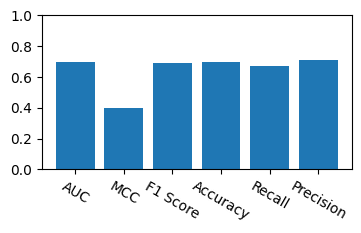

In [27]:
from sklearn.metrics import matthews_corrcoef, f1_score, accuracy_score, recall_score, precision_score
from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt

predicted_labels = np.argmax(valid_predictions, axis=1);labels = Y_valid

# 计算指标
auc_val = auc(roc_curve(labels, predicted_labels)[0],roc_curve(labels, predicted_labels)[1])
mcc = matthews_corrcoef(labels, predicted_labels)
f1 = f1_score(labels, predicted_labels)
accuracy = accuracy_score(labels, predicted_labels)
recall = recall_score(labels, predicted_labels)
precision = precision_score(labels, predicted_labels)

# 输出结果
print(f"AUC: {auc_val:.4f}")
print(f"MCC: {mcc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")

plt.figure(figsize=(4,2))
plt.bar([1,2,3,4,5,6],[auc_val,mcc,f1,accuracy,recall,precision])
plt.ylim([0,1])
plt.xticks([1,2,3,4,5,6],["AUC","MCC","F1 Score","Accuracy","Recall","Precision"],rotation=-30)
plt.show()